In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize as op
import plasmapy
from scipy import special as sp
from scipy import integrate
from tqdm import tqdm
import numba as nb
import math
from prettytable import PrettyTable
%config InlineBackend.figure_format = 'svg'

# self-consistent solution of $\kappa-sech^2$ electron hole

In [626]:
T = 1
# k = 0.1
# L = 2*np.pi/k
L = 200


vmax = 500 # 速度最大值
nx = 1000
nv = 5000
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)

## sech2分布
$$ f_u(w>0) = \frac{N_\kappa}{\sqrt{\pi\kappa\theta^2}} \left[ 1 + \frac{(\pm \sqrt{2w}+u)^2}{\kappa\theta^2} \right]^{-\kappa} $$
$$ N_\kappa = \frac{n_\infty \Gamma(\kappa)}{\Gamma(\kappa-1/2)} $$
$$ f_t(w<0) = \frac{N_\kappa}{\sqrt{\pi\kappa\theta^2}} \left( 1 - \frac{u^2}{\kappa\theta^2} \right)^{-\kappa} 
              \left[ 1+W \frac{2\kappa}{\kappa \theta^2 + u^2} 
                      \left(   1-\frac{2(\kappa+1)u^2}{\kappa\theta^2+u^2}  \right)
              \right]$$
其中$w=v^2/2-\phi$
## 理论自洽解
$$ \phi = \psi sech^2 \left(\frac{\sqrt{B_s}x}{2}\right) $$
$$ B_s = \frac{2n_\infty}{\theta^2} \left[ 1 -\frac{1}{2\kappa} + \frac{u}{\theta} Z_\kappa\left(\frac{u}{\theta}\right) \right] $$
$$ D_s = \frac{n_\infty (\kappa+1/2)(\kappa-1/2)}{\theta^4 \kappa^2 (\kappa+2)} 
            \left\{ _2F_1\left[2,2\kappa+3;\kappa+3;\frac{1}{2}(1+\frac{i}{\sqrt{\kappa}}\frac{u}{\theta})\right]
            + i \frac{\kappa+3/2}{\sqrt{\kappa}(\kappa+3)}\frac{u}{\theta} {}_2F_1\left[3,2\kappa+4;\kappa+4;\frac{1}{2}(1+\frac{i}{\sqrt{\kappa}}\frac{u}{\theta})\right]
            \right\}$$
$$ \theta = \sqrt{ \frac{\kappa-3/2}{\kappa} \frac{2T}{m} } $$

In [747]:
kappa = 10
# theta = np.sqrt(2.0-3.0/kappa)
theta = np.sqrt(2)

In [748]:
import mpmath as mp
mp.dps=10

def Bs_fun_nonvec(zeta):
    fac = 1j * (kappa+0.5) * (kappa-0.5) / kappa**1.5 / (kappa+1.0)
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp = np.complex128(mp.hyp2f1(1,2*kappa+2,kappa+2,z))
    zk = fac*hyp
    return 2.0/theta**2*(1.0 - 0.5/kappa + zeta*zk).real

def Ds_fun_nonvec(zeta):
    fac = (kappa+0.5) * (kappa-0.5) / kappa**2 / (kappa+2.0) / theta**4
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp1 = np.complex128(mp.hyp2f1(2,2*kappa+3,kappa+3,z))
    hyp2 = 1j*(kappa+1.5)/np.sqrt(kappa)/(kappa+3)*zeta*np.complex128(mp.hyp2f1(3,2*kappa+4,kappa+4,z))
    return fac*(hyp1+hyp2).real

def Es_fun_nonvec(zeta):
    fac = 32.0*np.sqrt(2)/45.0 * sp.gamma(kappa)/sp.gamma(kappa-0.5)/np.sqrt(kappa*np.pi)/theta
    es1 = (1+zeta**2/kappa)**(-kappa-4)*(kappa+1)/kappa**3/theta**4
    es2 = (2*kappa+3)*(2*kappa+1)*zeta**4 - 6*kappa*(2*kappa+3)*zeta**2 + 3*kappa**2
    return -fac*es1*es2

def Fs_fun_nonvec(zeta):
    fac1 = (kappa+0.5)*(kappa-0.5)*(2*kappa+3)*(2*kappa+4)
    fac2 = 4*theta**6*kappa**3*(kappa+2)*(kappa+3)*(kappa+4)
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp1 = np.complex128(mp.hyp2f1(4,2*kappa+5,kappa+5,z))
    hyp2 = 1j*(kappa+2.5)/np.sqrt(kappa)/(kappa+5) * zeta*np.complex128(mp.hyp2f1(5,2*kappa+6,kappa+6,z))
    return fac1/fac2 * (hyp1+hyp2).real

Bs_fun = np.vectorize(Bs_fun_nonvec)
Ds_fun = np.vectorize(Ds_fun_nonvec)
Es_fun = np.vectorize(Es_fun_nonvec)
Fs_fun = np.vectorize(Fs_fun_nonvec)

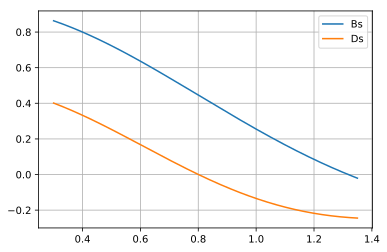

In [749]:
u = np.linspace(0.3,1.35,num=200)

Bs = Bs_fun(u/theta)
Ds = Ds_fun(u/theta)
psi = -3.0*Bs/Ds/2.0
plt.plot(u,Bs,label='Bs')
plt.plot(u,Ds,label='Ds')
plt.legend()
plt.grid()
plt.show()

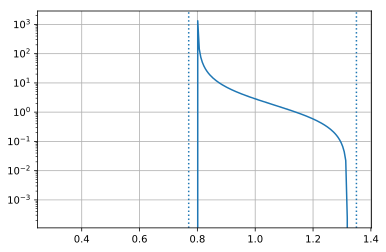

In [750]:
ul = 0.77
ur = 1.35
plt.plot(u,psi)
plt.axvline(ul,linestyle=':')
plt.axvline(ur,linestyle=':')
plt.yscale('log')
plt.grid()
plt.show()

In [877]:
u = 1.28
psi =-3.0*Bs_fun(u/theta)/Ds_fun(u/theta)/2.0 
delta = 2.0/np.sqrt(Bs_fun(u/theta))
print('delta',delta)
print('psi',psi)

delta 12.364596667664273
psi 0.1665708246000827


In [878]:
Bs = Bs_fun(u/theta)
Ds = Ds_fun(u/theta)
Es = Es_fun(u/theta)
Fs = Fs_fun(u/theta)

In [914]:
def psieq(p):
    return Bs/2.0 + Ds/3.0 * p + 2.0/7.0*Es*p**(1.5) #+ Fs/4 * p**2

In [915]:
sol = op.root(psieq,psi)
psi_new = sol.x[0]
print(sol.success,psi_new)

True 0.24559599542579397


In [916]:
xp = (x-L/2)/delta
phi = 1.5*psi_new*np.cosh(xp)**(-2)
c1 = phi[0]
c2 = phi[-1]

In [920]:
@nb.jit
def nonvec_f_fun_sech2(v,phi):
    r = 0
    v_waveframe = v
    w = (v_waveframe**2)/2-phi
    kt2 = kappa*theta**2
    fac = math.gamma(kappa)/math.gamma(kappa-0.5)/(math.pi*kt2)**0.5
    if w>0:
        if v_waveframe<=-(2*phi)**0.5:
            r=(1+(-(2*w)**0.5+u)**2/kt2)**(-kappa)
        elif v_waveframe>(2*phi)**0.5:
            r=(1+( (2*w)**0.5+u)**2/kt2)**(-kappa)
    else:
        r=(1+u**2/kt2)**(-kappa) * (1-w * (2*kappa/(kt2+u**2)) * (1-2*(kappa+1)*u**2/(kt2+u**2)) )
    return fac*r
f_fun_sech2 = np.vectorize(nonvec_f_fun_sech2)

In [921]:
for count in tqdm(range(10)):
    V,Phi=np.meshgrid(v,phi)
    f_matrix = f_fun_sech2(V,Phi)
    n_vector = f_matrix.sum(axis=1)*dv
    
    dx2 = dx*dx
    laplace = -2.0*np.eye(nx-2,k=0)+np.eye(nx-2,k=1)+np.eye(nx-2,k=-1)
    r = (1.0 - n_vector[1:nx-1])*dx2 + np.dot(laplace,phi[1:nx-1])
    
    # Dirichlet BC phi[0]=c1 phi[-1]=c2
    r[0]  += c1
    r[-1] += c2
    
    m = 2.0 + (n_vector[2:nx]-n_vector[0:nx-2])/(phi[2:nx]-phi[0:nx-2])*dx2
    nr_mat = np.diag(m) - np.eye(nx-2,k=1) - np.eye(nx-2,k=-1)
    dphi = np.linalg.solve(nr_mat,r)
    phi[1:nx-1] += dphi
    
    err = ((dphi/phi[1:nx-1])**2).sum()
    if err<= 1e-6:
        print("Sucess! Iteration counts =", count)
        break
print(err)

 40%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 4/10 [00:08<00:12,  2.10s/it]

Sucess! Iteration counts = 4
4.366401063891728e-09


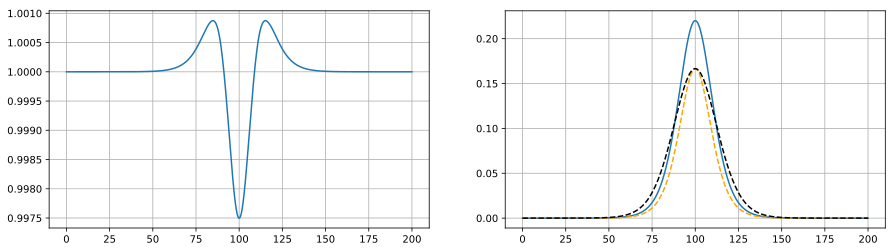

In [922]:
fig = plt.figure(figsize=(15,4))
ax1 = plt.subplot(121)
ax1.plot(x,n_vector)
ax1.grid()
ax3 = plt.subplot(122)
ax3.plot(x,phi)
ax3.plot(x,psi*np.cosh((x-L/2)/delta)**(-2),color='orange',linestyle='--')
ax3.plot(x,psi*np.cosh((x-L/2)/delta/2.0)**(-4),color='black',linestyle='--')
ax3.grid()
# ax3.set_xlim(0.3*L,0.7*L)
# ax3.set_yscale('log')
plt.show()

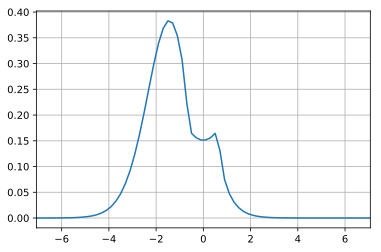

In [923]:
V,Phi=np.meshgrid(v,phi)
f_matrix = f_fun_sech2(V,Phi)
fv = f_matrix.sum(axis=0)*dx/L
plt.plot(v,f_matrix[int(nx/2),])
plt.xlim(-5*theta,5*theta)
# plt.ylim(0.05,0.31)
plt.grid()

In [924]:
def phi4_theo(x,a,da):
    xp = (x-L/2)/da
    return a*np.cosh(xp)**(-4)

def phi2_theo(x,a,da):
    xp = (x-L/2)/da
    return a*np.cosh(xp)**(-2)

from scipy.optimize import curve_fit
para4,pcov=curve_fit(phi4_theo,x,phi)
para2,pcov=curve_fit(phi2_theo,x,phi)
Ddelta = round(abs(para2[1]-delta)/para2[1]*100,2)
Dpsi = round(abs(para2[0]-psi)/para2[0]*100,2)  

Dpsi_new = round(abs(para2[0]-psi_new)/para2[0]*100,2)  

print('sech4 fit:',para4)
print('sech2 fit:',para2)
print('Dpsi     :',Dpsi,'%')
print('Ddelta   :',Ddelta,'%')
print('Dpsi_new:',Dpsi_new,'%')

sech4 fit: [ 0.2180094  19.48048338]
sech2 fit: [ 0.2210192  12.99894497]
Dpsi     : 24.64 %
Ddelta   : 4.88 %
Dpsi_new: 11.12 %


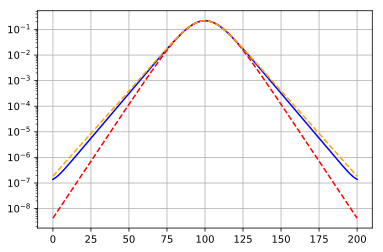

In [925]:
plt.plot(x,phi,color='blue')
plt.plot(x,phi4_theo(x,para4[0],para4[1]),'--',color='red')
plt.plot(x,phi2_theo(x,para2[0],para2[1]),'--',color='orange')
# plt.plot(x,phi2_theo(x,psi,delta),'--',color='green')
# plt.xlim(0.3*L,0.7*L)
plt.yscale('log')
plt.grid()
plt.show()

In [840]:
# mat.append([u,round(para2[1],3),round(delta,3),Ddelta,round(para2[0],3),round(psi,3),round(psi_new,3),Dpsi,Dpsi_new])

In [841]:
table = PrettyTable(['u','delta_sc','delta_th','delta_err(%)','psi_sc','psi_th','psi_th_new','psi_err(%)','psi_new_err(%)'])
for i in range(len(mat)):
    table.add_row(mat[i])
print('kappa=',kappa)
print(table)

kappa= 10
+------+----------+----------+--------------+--------+--------+------------+------------+----------------+
|  u   | delta_sc | delta_th | delta_err(%) | psi_sc | psi_th | psi_th_new | psi_err(%) | psi_new_err(%) |
+------+----------+----------+--------------+--------+--------+------------+------------+----------------+
| 1.25 |  9.826   |   9.17   |     6.68     | 0.464  |  0.31  |   0.433    |   33.16    |      6.73      |
| 1.26 |  10.612  |  9.957   |     6.17     | 0.376  | 0.261  |   0.357    |   30.54    |      5.0       |
| 1.27 |  11.601  |  10.975  |     5.39     | 0.294  | 0.213  |   0.284    |   27.65    |      3.45      |
| 1.28 |  12.999  |  12.365  |     4.88     | 0.221  | 0.167  |   0.216    |   24.64    |      2.37      |
| 1.29 |  15.012  |  14.428  |     3.89     | 0.154  | 0.121  |   0.152    |   21.06    |      1.34      |
| 1.3  |  18.619  |  17.989  |     3.39     | 0.094  | 0.078  |   0.093    |   17.04    |      0.79      |
| 1.31 |  27.379  |  26.72 

In [746]:
# mat = []

In [594]:
# mat = mat[0:-2]

In [926]:
psi_last = psi 
# psi_last = psi_next
psi_next = psi_last * (1.0 - psi_last**0.5*(6*Es/7/Ds))
# psi_new_appro = psi * (1.0 - psi**0.5*(6*Es/7/Ds) - psi*(3*Fs/Ds/4))
print(psi)
print(psi_next)
print(psi_new)
print(para2[0])

0.1665708246000827
0.21071078357437922
0.24559599542579397
0.2210192009444491


In [927]:
abs(psi_next-para2[0])/para2[0]*100

4.664037027561598